<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Машинное обучение и майнинг данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# Занятие 5. Продвинутые методы классификации и регрессии

## Часть 3. Xgboost в соревновании Kaggle Forest Cover Type Prediction

[Соревнование](https://www.kaggle.com/c/forest-cover-type-prediction). 
Задача учебная. Предлагается предсказывать тип лесного покрытия на участках 30х30 метров Национального заповедника Рузвельта в Колорадо.

Признаки (подробней на [странице](https://www.kaggle.com/c/forest-cover-type-prediction/data) соревнования):

- Elevation (высота) - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope (наклон) - Slope in degrees
- Horizontal_Distance_To_Hydrology (горизонтальное расстояние до воды) - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology (вертикальное расстояние до воды) - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways (горизонтальное расстояние до дорог) - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice 
- Horizontal_Distance_To_Fire_Points (горизонтальное расстояние до центров воспламенения) - Horz Dist to nearest wildfire ignition points 
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (тип почвы) - (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

**Подключаем библиотеки и загружаем данные. Используем [log_progress](https://github.com/alexanderkuk/log-progress) для отслеживания итераций в циклах.**

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.grid_search import GridSearchCV
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../scripts/')
from log_progress import log_progress

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_csv('../../data/forest_train.csv')
test = pd.read_csv('../../data/forest_test.csv')

In [3]:
def write_to_submission_file(predicted_labels, out_file,
                             target='Cover_Type', index_label="Id", init_index=15121):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(init_index, 
                                                  predicted_labels.shape[0] + init_index),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Создаем признаки.**

In [4]:
train['Under_water'] = train.Vertical_Distance_To_Hydrology < 0
test['Under_water'] = test.Vertical_Distance_To_Hydrology < 0

In [5]:
train['EVDtH'] = train.Elevation - train.Vertical_Distance_To_Hydrology
test['EVDtH'] = test.Elevation - test.Vertical_Distance_To_Hydrology

train['EHDtH'] = train.Elevation - train.Horizontal_Distance_To_Hydrology*0.2
test['EHDtH'] = test.Elevation - test.Horizontal_Distance_To_Hydrology*0.2

In [6]:
train['Distanse_to_Hydrolody'] = (train['Horizontal_Distance_To_Hydrology'] ** 2 + 
                                  train['Vertical_Distance_To_Hydrology']**2) ** 0.5
test['Distanse_to_Hydrolody'] = (test['Horizontal_Distance_To_Hydrology']**2 + 
                                 test['Vertical_Distance_To_Hydrology']**2) ** 0.5

train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology'] + \
    train['Horizontal_Distance_To_Fire_Points']
test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology'] + \
    test['Horizontal_Distance_To_Fire_Points']

train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology'] - \
                                train['Horizontal_Distance_To_Fire_Points'])
test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology'] - \
                           test['Horizontal_Distance_To_Fire_Points'])

train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology'] + \
                            train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology'] + \
                           test['Horizontal_Distance_To_Roadways'])

train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology'] - \
                            train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology'] - \
                           test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points'] + \
                           train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points'] + \
                          test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points'] - \
                           train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points'] - \
                          test['Horizontal_Distance_To_Roadways'])

In [7]:
y = train['Cover_Type']
X_train = train.drop(['Cover_Type', 'Id'], axis=1)
X_test = test.drop(['Id'], axis=1)

In [8]:
y = y - 1 # Чтоб классы нумеровались от о до 6

In [9]:
param = {}
param['nthread'] = 4
param['max_depth'] = 6
param['lambda'] = 1
param['eta'] = 1
param['min_child_weight'] = 1
param['eval_metric'] = 'merror'
param['max_delta_step'] = 1
param['objective'] = "multi:softprob"
param['num_class'] = 7
param['silent'] = 1
best_num_round = 30

**Есть у Xgboost одно неудобство - он  "не любит" нижние подчеркивания в названиях признаков.**

In [10]:
X_train.columns = [col.replace('_', '') for col in X_train.columns]
X_test.columns = [col.replace('_', '') for col in X_test.columns]

In [11]:
dtrain = xgb.DMatrix(X_train, y)

In [12]:
xgbCvResult = xgb.cv(param, dtrain, 
                      num_boost_round=50,  
                      nfold=10, show_progress=True)

[0]	cv-test-merror:0.3433861+0.0159192563548	cv-train-merror:0.3190254+0.00560773100639
[1]	cv-test-merror:0.234193+0.0079719220518	cv-train-merror:0.1969944+0.00346901963673
[2]	cv-test-merror:0.2195105+0.00894417228423	cv-train-merror:0.1746693+0.00385080064532
[3]	cv-test-merror:0.2088623+0.00887704373145	cv-train-merror:0.1552395+0.00421264599154
[4]	cv-test-merror:0.1964285+0.00926880400321	cv-train-merror:0.1383598+0.00582980311503
[5]	cv-test-merror:0.1861771+0.0112599269753	cv-train-merror:0.1240006+0.00528450437033
[6]	cv-test-merror:0.1800266+0.0112658060093	cv-train-merror:0.1117725+0.0040774715511
[7]	cv-test-merror:0.1722882+0.0100617801685	cv-train-merror:0.1024912+0.00348245381305
[8]	cv-test-merror:0.167328+0.0086081957343	cv-train-merror:0.0905864+0.00553824006702
[9]	cv-test-merror:0.1623016+0.00953463481419	cv-train-merror:0.0797252+0.00425869812971
[10]	cv-test-merror:0.1568122+0.00906080146345	cv-train-merror:0.0688714+0.00387203295957
[11]	cv-test-merror:0.1542328

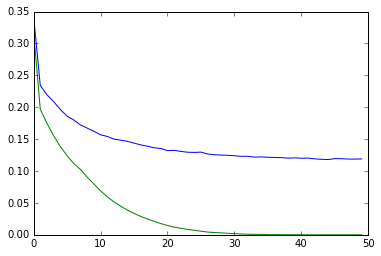

In [13]:
plot(range(xgbCvResult.shape[0]), xgbCvResult['test-merror-mean'])
plot(range(xgbCvResult.shape[0]), xgbCvResult['train-merror-mean'])

**Далее будем подбирать параметры с помощью кросс-валидации.**

In [14]:
%%time
depth_values = np.arange(10)
errors = []
for dep in log_progress(depth_values):
    param['max_depth'] = dep
    cv_results = xgb.cv(param, dtrain, 
                      num_boost_round=30,  
                      nfold=5, show_progress=False)
    errors.append(cv_results['test-merror-mean'].min())

CPU times: user 5min 7s, sys: 2.29 s, total: 5min 9s
Wall time: 5min 14s


8


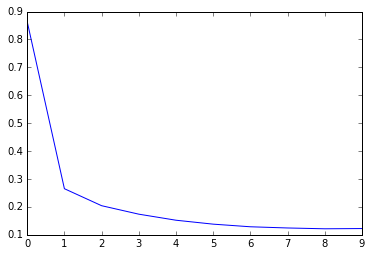

In [15]:
print(depth_values[np.argmin(errors)])
plot(depth_values, errors)

In [16]:
%%time
gamma_values = np.linspace(0,4,10)
errors = []
for gam in log_progress(gamma_values):
    param['gamma'] = gam
    param['max_depth'] = 8
    cv_results = xgb.cv(param, dtrain, 
                      num_boost_round=15,  
                      nfold=5, show_progress=False)
    errors.append(cv_results['test-merror-mean'].min())

CPU times: user 4min 23s, sys: 1.99 s, total: 4min 25s
Wall time: 4min 30s


0.0


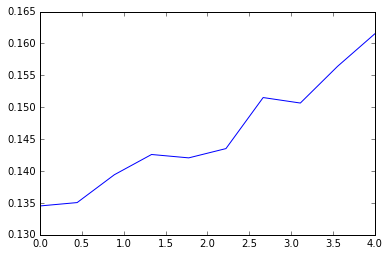

In [17]:
print(gamma_values[np.argmin(errors)])
plot(gamma_values, errors)

In [18]:
%%time
lambda_values = np.linspace(0,4,10)
errors = []
for lam in log_progress(lambda_values):
    param['gamma'] = 0
    param['max_depth'] = 8
    param['lambda'] = lam
    cv_results = xgb.cv(param, dtrain, 
                      num_boost_round=5,  
                      nfold=5, show_progress=False)
    errors.append(cv_results['test-merror-mean'].min())

CPU times: user 1min 31s, sys: 759 ms, total: 1min 32s
Wall time: 1min 34s


3.11111111111


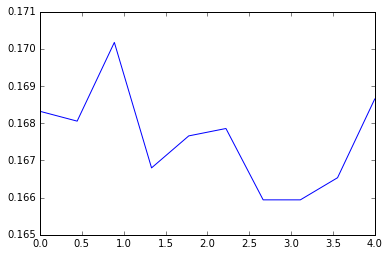

In [19]:
print(lambda_values[np.argmin(errors)])
plot(lambda_values, errors)

In [20]:
%%time
eta_values = np.linspace(0,1,10)
errors = []
for eta in log_progress(eta_values):
    param['gamma'] = 0
    param['max_depth'] = 8
    param['lambda'] = 3.11
    param['eta'] = eta
    cv_results = xgb.cv(param, dtrain, 
                      num_boost_round=5,  
                      nfold=5, show_progress=False)
    errors.append(cv_results['test-merror-mean'].min())

CPU times: user 1min 32s, sys: 786 ms, total: 1min 33s
Wall time: 1min 34s


1.0


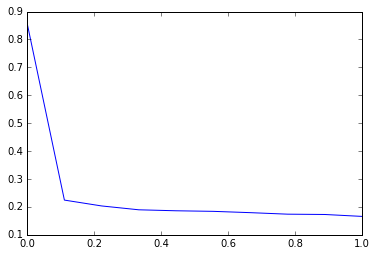

In [21]:
print(eta_values[np.argmin(errors)])
plot(eta_values, errors)

In [22]:
%%time
child_weihts = np.arange(10)
errors = []
for child_weiht in log_progress(child_weihts):
    param['gamma'] = 0
    param['max_depth'] = 8
    param['lambda'] = 3.11
    param['eta'] = 1
    param['min_child_weight'] = child_weiht
    cv_results = xgb.cv(param, dtrain, 
                      num_boost_round=5,  
                      nfold=5, show_progress=False)
    errors.append(cv_results['test-merror-mean'].min())

CPU times: user 1min 26s, sys: 756 ms, total: 1min 27s
Wall time: 1min 28s


1


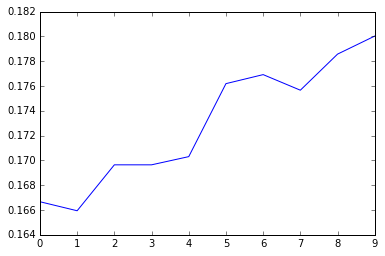

In [23]:
print(child_weihts[np.argmin(errors)])
plot(child_weihts, errors)

In [24]:
param['gamma'] = 0
param['max_depth'] = 8
param['lambda'] = 3.11
param['eta'] = 1
param['min_child_weight'] = 1

dtrain = xgb.DMatrix(X_train, y)
            
xgbCvResult =  xgb.cv(param, dtrain, num_boost_round=50, 
                      nfold=10, show_progress=True)

[0]	cv-test-merror:0.3255291+0.0139166089796	cv-train-merror:0.2941872+0.00418274674825
[1]	cv-test-merror:0.206283+0.00813505691437	cv-train-merror:0.1457306+0.0043829811818
[2]	cv-test-merror:0.19041+0.00896860447338	cv-train-merror:0.1220608+0.00303039175025
[3]	cv-test-merror:0.1782407+0.011271438693	cv-train-merror:0.1018887+0.00231146840991
[4]	cv-test-merror:0.1652117+0.00988889793708	cv-train-merror:0.0845897+0.00228488214357
[5]	cv-test-merror:0.1575397+0.00919190599441	cv-train-merror:0.070782+0.00304225238927
[6]	cv-test-merror:0.1523148+0.0104239368935	cv-train-merror:0.0581572+0.00254828608284
[7]	cv-test-merror:0.1490082+0.0109118828513	cv-train-merror:0.0485965+0.00223276139567
[8]	cv-test-merror:0.1460317+0.0126071812238	cv-train-merror:0.0390212+0.0017995093109
[9]	cv-test-merror:0.1394181+0.011606528434	cv-train-merror:0.0309451+0.00260778470929
[10]	cv-test-merror:0.1357143+0.0100207154241	cv-train-merror:0.0235522+0.00232814350073
[11]	cv-test-merror:0.133598+0.0112

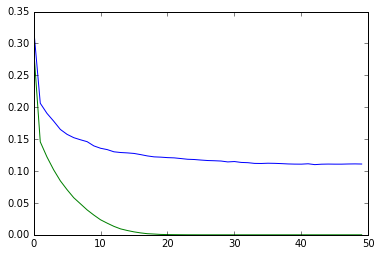

In [25]:
plot(range(xgbCvResult.shape[0]), xgbCvResult['test-merror-mean'])
plot(range(xgbCvResult.shape[0]), xgbCvResult['train-merror-mean'])

In [26]:
best_num_round = np.argmin(xgbCvResult['test-merror-mean'])

**Сделаем прогноз для всей тестовой выборки.**

In [27]:
bestXgb = xgb.train(param, dtrain, best_num_round)

In [28]:
dtest = xgb.DMatrix(X_test)

In [29]:
xgboost_predict_proba = bestXgb.predict(dtest)

In [31]:
xgboost_prediction = np.argmax(xgboost_predict_proba,
                                         axis=1)

**Важный шаг: мы вычитали из целевых меток 1, теперь добавляем.**

In [33]:
xgboost_prediction += 1

In [34]:
write_to_submission_file(xgboost_prediction, 
                         '../../output/forest_cover_type_xgboost.csv')

**У такой посылки на Kaggle результат - 0.77522.**